In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

2024-12-11 23:27:53.517649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733959673.536161   19292 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733959673.541982   19292 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import monai
print(dir(monai.networks.nets))
print(monai.__version__)

/mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-11 23:28:07.839091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733959687.857671   19247 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733959687.863316   19247 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MedNeXt', 'MedNeXtB', 'MedNeXtL', 'MedNeXtLarge', 'MedNeXtM', 'MedNeXtMedium', 'MedNeXtS', 'MedNeXtSmall', 'MedNext', 'MedNextB',

## Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")

#training_dir = os.path.join(root_dir, "train")
#testing_dir = os.path.join(root_dir, "test")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing


(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


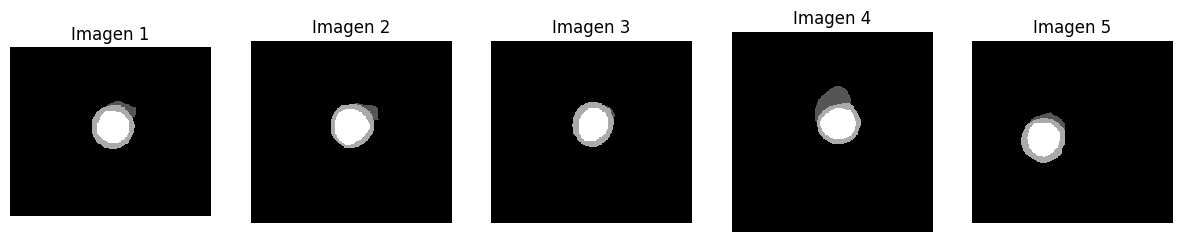

In [6]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [7]:
all_files = training_files + testing_files
images = [nib.load(file).get_fdata() for file in all_files]
image_shapes = [img.shape for img in images]
print(image_shapes)
average_shape = np.mean(image_shapes, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [8]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [9]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y escala la intensidad de la imagen
from monai.transforms import CastToTyped
crop_size = (224, 224, 10)

def one_hot_transform(label, num_classes=4):
    # Aplica one-hot encoding a las etiquetas
    one_hot = torch.nn.functional.one_hot(label.long(), num_classes=num_classes)
    one_hot = one_hot.permute(3, 0, 1, 2)  # (clases, ancho, alto, profundidad)
    return one_hot


all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="RAS"),
    #transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear")),
    transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("nearest")),
    #transforms.CenterSpatialCropd(keys=["image"], roi_size=(96, 96, 64)),
    transforms.CenterSpatialCropd(keys=["image"], roi_size=crop_size),
    #transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    transforms.Resized(keys=["image"], spatial_size=(154, 154, 6), mode=('nearest-exact')),  
    transforms.Lambdad(keys="image", func=lambda x: one_hot_transform(x[0], num_classes=4)),
]

In [10]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación
#  channel = 0  # 0 = Flair
#  assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 154, 154, 6])
Image shape torch.Size([4, 154, 154, 6])


## Visualise examples from the training set

Tamaño de la máscara cargada: torch.Size([1, 4, 154, 154, 6])
Valores en los canales (min, max) antes de la visualización:
Canal 0: min = 0, max = 1
Canal 1: min = 0, max = 1
Canal 2: min = 0, max = 1
Canal 3: min = 0, max = 1


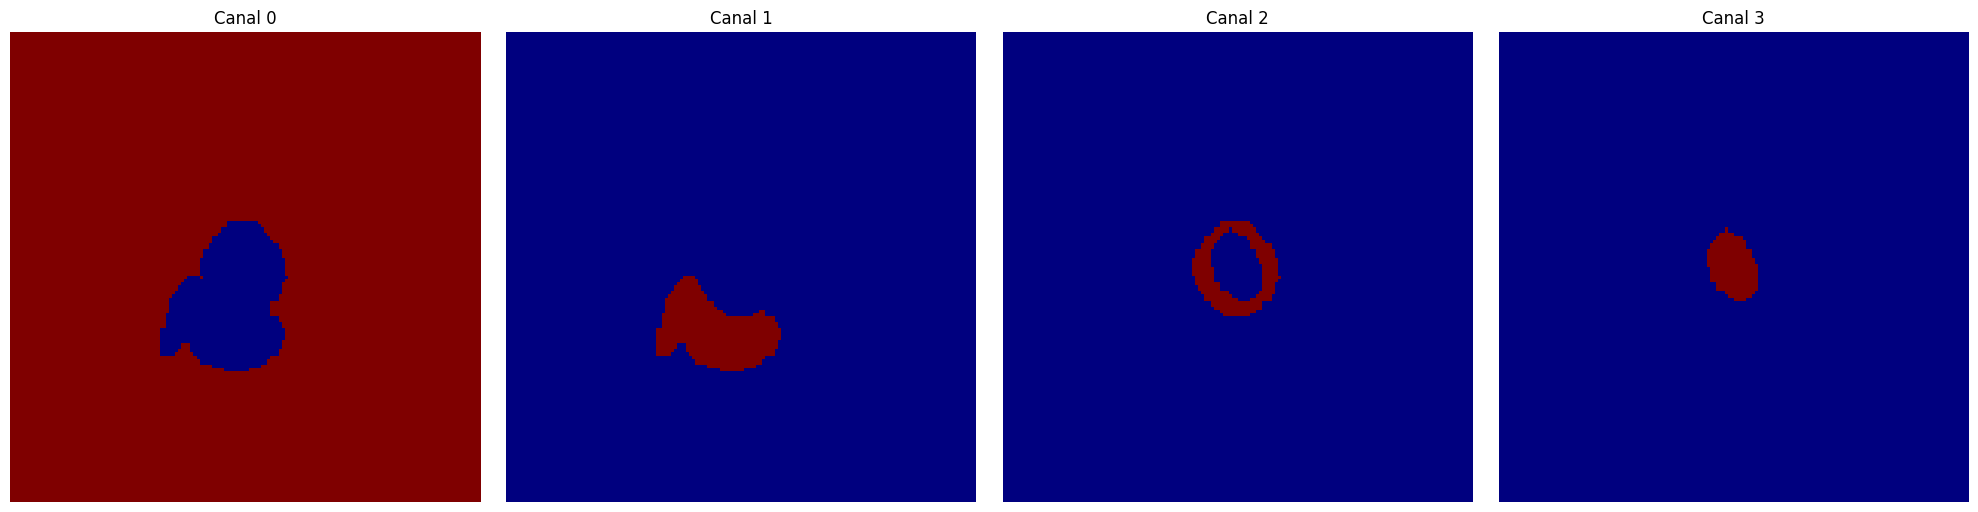

In [11]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image'] 

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

# Verificar los valores en los canales para asegurarse de que hay información
print(f"Valores en los canales (min, max) antes de la visualización:")
for c in range(image_slice_axial.size(0)):
    print(f"Canal {c}: min = {image_slice_axial[c].min()}, max = {image_slice_axial[c].max()}")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow(image_slice_axial[i].cpu().numpy(), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Canal {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


Tamaño de la máscara cargada: torch.Size([1, 4, 154, 154, 6])


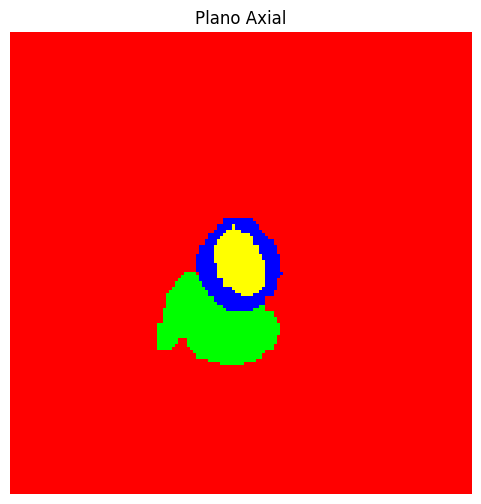

In [12]:
# Crear una imagen combinada utilizando colores distintos para cada canal
# Inicializamos una imagen RGB para combinar las clases
combined_image = np.zeros((image_slice_axial.shape[1], image_slice_axial.shape[2], 3))  # (alto, ancho, 3 canales RGB)

# Canal 0 -> Rojo, Canal 1 -> Verde, Canal 2 -> Azul, Canal 3 -> Amarillo
for i in range(4): 
    mask = image_slice_axial[i].cpu().numpy() 
    if i == 0:
        combined_image[:, :, 0] = np.maximum(combined_image[:, :, 0], mask)  # Rojo
    elif i == 1:
        combined_image[:, :, 1] = np.maximum(combined_image[:, :, 1], mask)  # Verde
    elif i == 2:
        combined_image[:, :, 2] = np.maximum(combined_image[:, :, 2], mask)  # Azul
    elif i == 3:
        combined_image[:, :, 0] = np.maximum(combined_image[:, :, 0], mask)  # Rojo
        combined_image[:, :, 1] = np.maximum(combined_image[:, :, 1], mask)  # Verde


print(f"Tamaño de la máscara cargada: {image_tensor.shape}")
plt.figure(figsize=(6, 6))
plt.imshow(combined_image, interpolation='none')
plt.title("Plano Axial")
plt.axis("off")
plt.show()


Tamaño de la máscara cargada: torch.Size([1, 4, 154, 154, 6])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


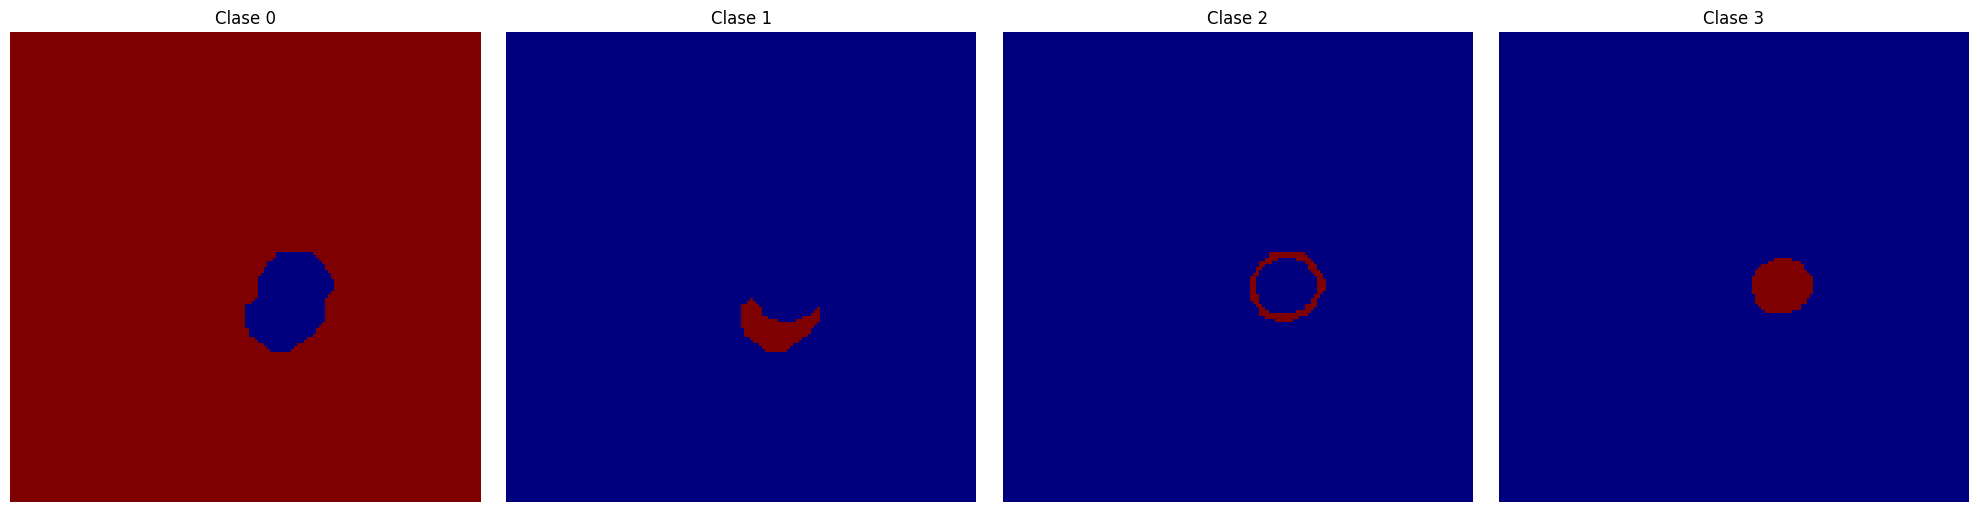

In [13]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

# selecciona el índice de la clase (canal) con el valor máximo para cada voxel en el slice axial.
one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


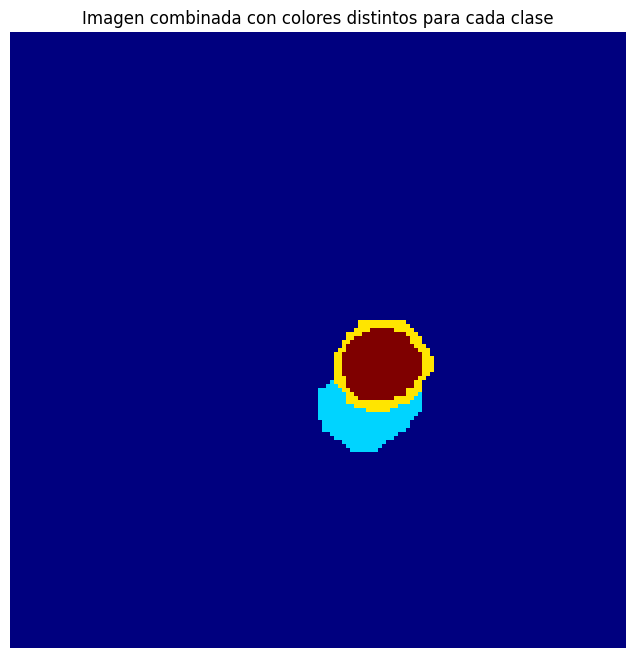

In [15]:
# Obtener el slice axial del tensor de imagen
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

# Convertir a representación one-hot
one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

# Crear la imagen combinada con colores distintos para cada clase
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # S1
            nn.Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            # S2
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            # S3
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            # S4
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
        )
        
        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 64),
            nn.Linear(64, 125),
            nn.ReLU(),
        )
        
        # Decoder      
        self.decoder = nn.Sequential(
            # S4
            nn.ConvTranspose3d(64, 64, kernel_size=(7, 7, 7), stride=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            # S3
            nn.ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            # S2
            nn.ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            # S1
            nn.ConvTranspose3d(16, 16, kernel_size=(4, 4, 1), stride=(2, 2, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        latent_space = self.fc(encoded.flatten(start_dim=1))
        decoded = self.decoder(encoded)
        decoded = F.interpolate(decoded, size=x.shape[2:], mode="trilinear", align_corners=False) 
        # decoded = F.softmax(decoded, dim=1)
        return decoded, latent_space
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 154, 154, 6).to(device) 
sample_output, latent_space = model(sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Latent space shape: {latent_space.shape}")
print(model) 

Input shape: torch.Size([1, 4, 154, 154, 6])
Output shape: torch.Size([1, 4, 154, 154, 6])
Latent space shape: torch.Size([1, 125])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): ReLU()
    (6): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (9): ReLU()
    (10): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (11): ReLU()
    (12): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(1, 1, 1))
    (13): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=64, bias=True)

In [32]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()

# Entrenamiento
num_epochs = 20
val_interval = 2
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_data in tqdm(train_loader):
        inputs = batch_data["image"].to(device).float() 
        outputs, _ = model(inputs)

        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
    # Validación
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device).float()
                val_outputs, _ = model(val_inputs)
                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

100%|██████████| 200/200 [00:11<00:00, 17.45it/s]


Epoch [1/20], Train Loss: 0.2225


100%|██████████| 200/200 [00:11<00:00, 17.77it/s]


Epoch [2/20], Train Loss: 0.0693
Epoch [2/20], Validation Loss: 0.0586


100%|██████████| 200/200 [00:11<00:00, 17.48it/s]


Epoch [3/20], Train Loss: 0.0533


100%|██████████| 200/200 [00:11<00:00, 17.55it/s]


Epoch [4/20], Train Loss: 0.0511
Epoch [4/20], Validation Loss: 0.0579


100%|██████████| 200/200 [00:11<00:00, 17.45it/s]


Epoch [5/20], Train Loss: 0.0500


100%|██████████| 200/200 [00:11<00:00, 17.50it/s]


Epoch [6/20], Train Loss: 0.0482
Epoch [6/20], Validation Loss: 0.0533


100%|██████████| 200/200 [00:11<00:00, 17.54it/s]


Epoch [7/20], Train Loss: 0.0450


100%|██████████| 200/200 [00:11<00:00, 17.43it/s]


Epoch [8/20], Train Loss: 0.0440
Epoch [8/20], Validation Loss: 0.0459


100%|██████████| 200/200 [00:11<00:00, 17.56it/s]


Epoch [9/20], Train Loss: 0.0422


100%|██████████| 200/200 [00:11<00:00, 17.72it/s]


Epoch [10/20], Train Loss: 0.0398
Epoch [10/20], Validation Loss: 0.0416


100%|██████████| 200/200 [00:11<00:00, 17.71it/s]


Epoch [11/20], Train Loss: 0.0360


100%|██████████| 200/200 [00:11<00:00, 17.54it/s]


Epoch [12/20], Train Loss: 0.0357
Epoch [12/20], Validation Loss: 0.0372


100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Epoch [13/20], Train Loss: 0.0336


100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


Epoch [14/20], Train Loss: 0.0329
Epoch [14/20], Validation Loss: 0.0371


100%|██████████| 200/200 [00:11<00:00, 17.74it/s]


Epoch [15/20], Train Loss: 0.0311


100%|██████████| 200/200 [00:11<00:00, 17.74it/s]


Epoch [16/20], Train Loss: 0.0298
Epoch [16/20], Validation Loss: 0.0354


100%|██████████| 200/200 [00:11<00:00, 17.66it/s]


Epoch [17/20], Train Loss: 0.0300


100%|██████████| 200/200 [00:11<00:00, 17.70it/s]


Epoch [18/20], Train Loss: 0.0294
Epoch [18/20], Validation Loss: 0.0335


100%|██████████| 200/200 [00:11<00:00, 17.69it/s]


Epoch [19/20], Train Loss: 0.0286


100%|██████████| 200/200 [00:11<00:00, 17.79it/s]


Epoch [20/20], Train Loss: 0.0287
Epoch [20/20], Validation Loss: 0.0335


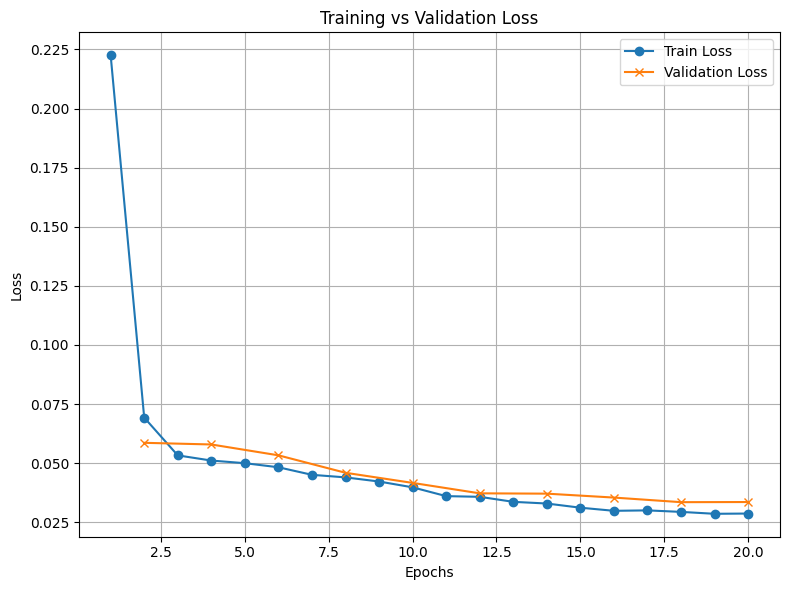

In [33]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Valores del voxel en (2, 2, 2) antes del argmax: [  8.953164  -10.797998   -5.8662605 -19.74565  ]
Dimensiones de la entrada: (1, 4, 154, 154, 6)
Valores de los voxeles de la entrada: min=0.0, max=1.0
Dimensiones de la salida: (1, 4, 154, 154, 6)
Valores de los voxeles de la salida: min=-329.02227783203125, max=121.7057876586914


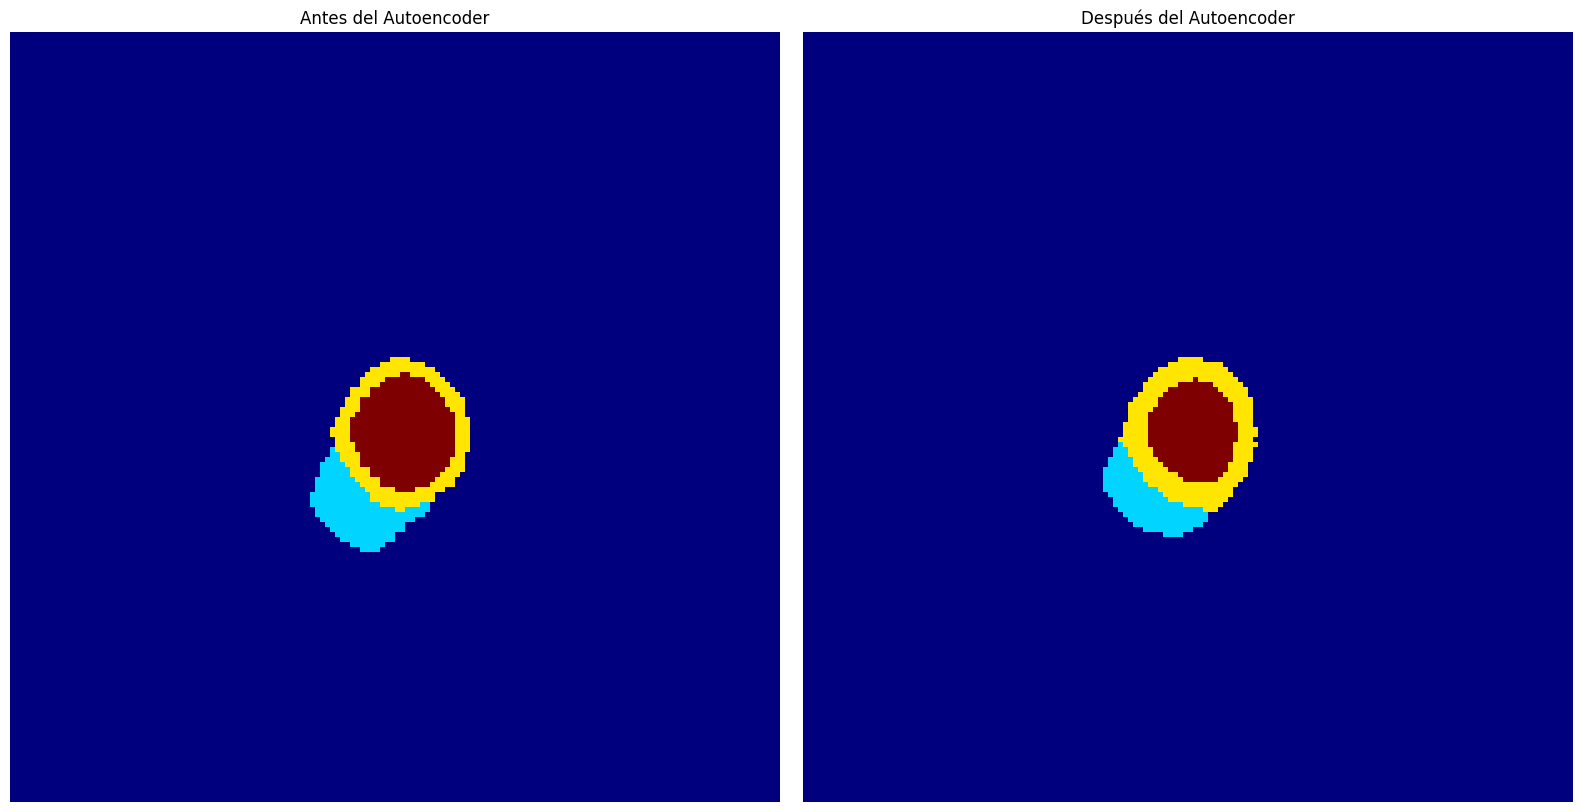

In [ ]:
def representation(image_tensor, model, device, voxel_coords=(2, 2, 2)):
    image_tensor = image_tensor.to(device).float()
    
    # Dimensiones de entrada
    input_shape = tuple(image_tensor.shape)
    input_min, input_max = torch.min(image_tensor).item(), torch.max(image_tensor).item()
    
    model.eval()  
    with torch.no_grad():
        outputs, _ = model(image_tensor)
    
    # Dimensiones de salida
    output_shape = tuple(outputs.shape)
    output_min, output_max = torch.min(outputs).item(), torch.max(outputs).item()
    
    z, y, x = voxel_coords
    if z >= output_shape[2] or y >= output_shape[3] or x >= output_shape[4]:
        raise IndexError(
            f"Las coordenadas del voxel {voxel_coords} están fuera de los límites de salida: {output_shape[2:]}."
        )
    voxel_values = outputs[0, :, z, y, x].cpu().numpy() # Obtener valores de un voxel en todos los canales
    print(f"Valores del voxel en {voxel_coords} antes del argmax: {voxel_values}")
    
    print(f"Dimensiones de la entrada: {input_shape}")
    print(f"Valores de los voxeles de la entrada: min={input_min}, max={input_max}")
    print(f"Dimensiones de la salida: {output_shape}")
    print(f"Valores de los voxeles de la salida: min={output_min}, max={output_max}")
    
    
    depth_idx = image_tensor.size(-1) // 2  # Índice axial (medio)
    
    # Obtener representación antes del autoencoder
    image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)
    one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
    combined_image_input = np.zeros_like(one_hot_representation, dtype=np.float32)
    for i in range(4):
        combined_image_input[one_hot_representation == i] = i / 3 
    
    # Obtener representación después del autoencoder
    output_slice_axial = outputs[0, :, :, :, depth_idx].cpu().detach().numpy()
    output_one_hot_representation = np.argmax(output_slice_axial, axis=0)
    combined_image_output = np.zeros_like(output_one_hot_representation, dtype=np.float32)
    for i in range(4): 
        combined_image_output[output_one_hot_representation == i] = i / 3 

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    axs[0].imshow(combined_image_input, cmap="jet", vmin=0, vmax=1)
    axs[0].set_title("Antes del Autoencoder")
    axs[0].axis("off")
    axs[1].imshow(combined_image_output, cmap="jet", vmin=0, vmax=1)
    axs[1].set_title("Después del Autoencoder")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

check_data = next(iter(val_loader))
image_tensor = check_data["image"]

representation(image_tensor, model, device, voxel_coords=(2, 2, 2))

Min: 0.0, Max: 3.0, Mean: 0.07816804945468903, Std: 0.4326491951942444
Input shape: torch.Size([1, 1, 154, 154, 6])
Output shape: torch.Size([1, 1, 154, 154, 6])
Input image shape: (1, 154, 154, 6)
Output image shape: (1, 154, 154, 6)
Output Min: -0.024922387674450874, Max: 3.377908229827881, Mean: 0.09054011106491089, Std: 0.4381781816482544


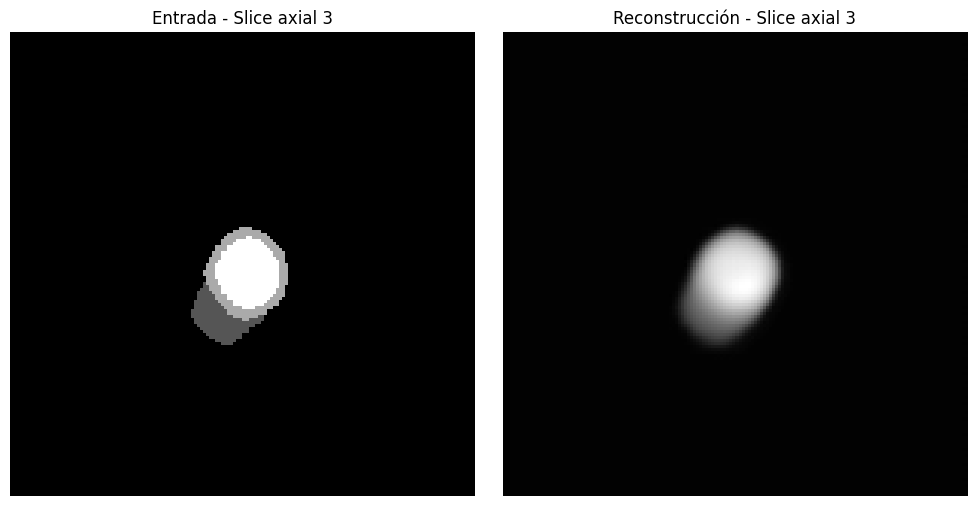

In [ ]:
'''def visualize_axial_reconstruction(model, data_loader, device, num_images=1):
    model.eval()
    with torch.no_grad():
     
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        
        # reconstrucciones del modelo
        outputs = model(inputs)

        for i in range(min(num_images, len(inputs))):
            input_image = inputs[i].cpu().numpy()
            output_image = outputs[i].cpu().numpy()
            
            outputs = model(inputs)
            outputs_np = outputs.cpu().numpy()
            
            print(f"Input shape: {inputs.shape}")
            print(f"Output shape: {outputs.shape}")
            print(f"Input image shape: {input_image.shape}")
            print(f"Output image shape: {output_image.shape}")

            print(f"Output Min: {outputs_np.min()}, Max: {outputs_np.max()}, Mean: {outputs_np.mean()}, Std: {outputs_np.std()}")

            # slice axial en el centro
            slice_idx = input_image.shape[-1] // 2
            input_slice = input_image[0, :, :, slice_idx]  
            output_slice = output_image[0, :, :, slice_idx]


            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(input_slice, cmap="gray")
            ax[0].set_title(f"Entrada - Slice axial {slice_idx}")
            ax[0].axis('off')
            ax[1].imshow(output_slice, cmap="gray")
            ax[1].set_title(f"Reconstrucción - Slice axial {slice_idx}")
            ax[1].axis('off')
            plt.tight_layout()
            plt.show()

visualize_axial_reconstruction(model, val_loader, device)'''
